<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/Structured_Fraud_Credit_Card_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import autokeras as ak

In [3]:
df = pd.read_csv('http://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/raw/master/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
x = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

# ratio of label on total data
# value_count-->各類資料出現次數, count-->資料總筆數(total raw number)
print(y.value_counts()/y.count())

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

0    0.998273
1    0.001727
Name: Class, dtype: float64


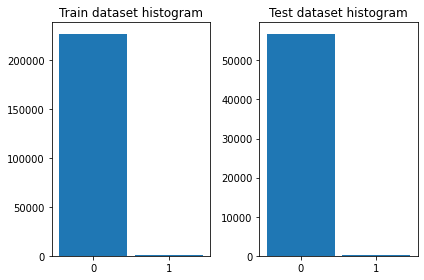

In [6]:
fig = plt.figure()
bin = np.arange(np.unique(y_train).size+1)

ax = fig.add_subplot(1, 2, 1)
ax.set_xticks(bin)
plt.hist(y_train, bins=bin-0.5, rwidth=0.9)
ax.set_title('Train dataset histogram')

ax = fig.add_subplot(1, 2, 2)
ax.set_xticks(bin)
plt.hist(y_test, bins=bin-0.5, rwidth=0.9)
ax.set_title('Test dataset histogram')

plt.tight_layout()
plt.show()

# Model

In [8]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

# input node
input_node = ak.StructuredDataInput()

# Structured processing node
output_node = ak.StructuredDataBlock()(input_node)

# Classification node
output_node = ak.ClassificationHead()(output_node)

clf = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=5)
clf.fit(x_train, y_train, callbacks=callbacks)

Trial 5 Complete [00h 18m 35s]
val_loss: 0.0033858371898531914

Best val_loss So Far: 0.0033520138822495937
Total elapsed time: 02h 09m 12s
INFO:tensorflow:Oracle triggered exit
7121/7121 [==============================] - 24s 3ms/step - loss: 0.3130 - accuracy: 0.9172
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


# Evaluate

In [9]:
clf.evaluate(x_test, y_test)

1781/1781 [==============================] - 5s 2ms/step - loss: 0.1400 - accuracy: 0.9959


[0.13995833694934845, 0.9959446787834167]

In [10]:
predicted = clf.predict(x_test).flatten()

# matrics 
from sklearn.metrics import f1_score, average_precision_score, classification_report

print('F1 score:', f1_score(y_test, predicted).round(3))
print('PR AUC score:', average_precision_score(y_test, predicted).round(3))
print('')
print(classification_report(y_test, predicted))

1781/1781 [==============================] - 4s 2ms/step
F1 score: 0.115
PR AUC score: 0.015

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.09      0.15      0.11       101

    accuracy                           1.00     56962
   macro avg       0.55      0.57      0.56     56962
weighted avg       1.00      1.00      1.00     56962



# Inblance Data

In [ ]:
# Method 1: set weight manually
# set class 0's weight to be 1
# set class 1's weight to be 100
class_weights={0:1, 1:100}

In [ ]:
# Method 2: sklearn weight computing automatically
from sklearn.utils.class_weight import compute_class_weight

# weight computing (return a list)
class_weights = compute_class_weight('blanced', classes=np.unique(y_train), y=y_train)

# convert list to panda series, and then convert to dict
class_weights = pd.Series(class_weights).to_dict()

class_weights

# Model Training with specified weight

In [ ]:
# specified metrics
metrics = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='pr_auc', curve='PR')]

callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

input_node = ak.StructuredDataInput()
output_node = ak.StructuredDataBlock()(input_node)
output_node = ak.ClassificationHead()(output_node)

# specified metrics
# 加入權重比例後,理論上模型較難收斂,需調整trials次數以保證找到較好的模型
clf = ak.AutoModel(inputs=input_node, outputs=output_node, metrics=metrics, max_trials=60, overwrite=True)

# specified class_weights
clf.fit(x_train, y_train, class_weight=class_weights, callbacks=callbacks)

# Model optimization with specified metric 

In [ ]:
import keras_tuner as kt

# specified metrics
metrics = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='pr_auc', curve='PR')]
      
# 指定模型搜尋指標改為val_pr_auc,而非預設的val_loss
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5),
        monitor='val_pr_auc', mode='max']

input_node = ak.StructuredDataInput()
output_node = ak.StructuredDataBlock()(input_node)
output_node = ak.ClassificationHead()(output_node)

# specified metrics 指定模型優化的指標為何
# pr_auc指標與驗證集的val_pr_auc不是ak的內建指標,因此需使用keras tuner的objective class,並指定direction是要最大化auc_curve
clf = ak.AutoModel(inputs=input_node, outputs=output_node,
          objective=kt.Objective('val_pr_auc', direction='max'), 
          metrics=metrics, 
          max_trials=60, overwrite=True)

# specified class_weights
clf.fit(x_train, y_train, 
    class_weight=class_weights, callbacks=callbacks)

In [ ]:
predicted = clf.predict(x_test).flatten()

# matrics 
from sklearn.metrics import f1_score, average_precision_score, classification_report

print('F1 score:', f1_score(y_test, predicted).round(3))
print('PR AUC score:', average_precision_score(y_test, predicted).round(3))
print('')
print(classification_report(y_test, predicted))

# Visualization

In [11]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 29)               0         
 ltiCategoryEncoding)                                            
                                                                 
 dense (Dense)               (None, 32)                960       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

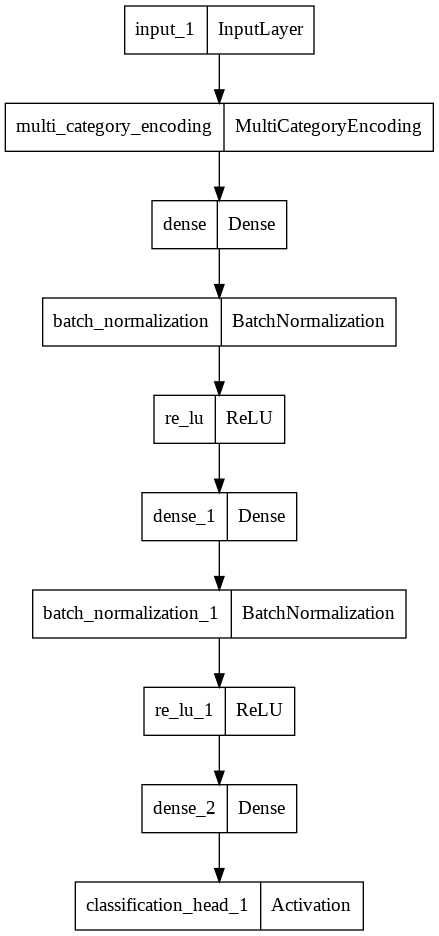

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model)